<a href="https://colab.research.google.com/github/Vitalitse/MNIST/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
from keras.datasets import mnist 
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt   
from keras.models import Sequential  
from keras.layers.core import Dense, Dropout, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten, AvgPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization

In [138]:
# Load the mnist data
(features_train, target_train), (features_test, target_test) = mnist.load_data()

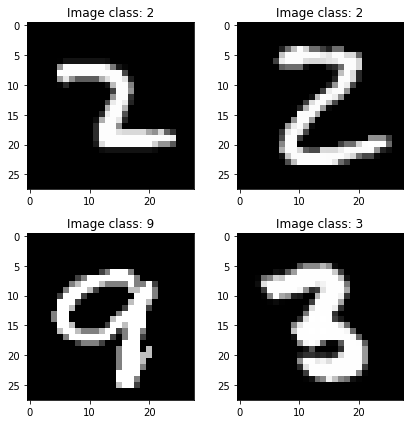

In [140]:
#See example of 4 imgaes from our train data

#Large figures
plt.rcParams['figure.figsize'] = (6,6)

#Chose 4 random numbers and present with their classes
for i in range (4):
  plt.subplot(2,2,i+1)
  #Choose random image
  number = random.randint(0, len(features_train))
  plt.imshow(features_train[number], cmap='gray')
  plt.title('Image class: {}'.format(target_train[number]))

plt.tight_layout()  

# Convolutional Neural Networks

In [142]:
print('Train shape:',features_train.shape)
print('Test shape:',features_test.shape)

Train shape: (60000, 28, 28)
Test shape: (10000, 28, 28)


In [144]:
# We will reshape dimentions to represent one color/single channel to use CNN, becuase CNNs are designed to the image as an RGB image
# Normalaize the data by dividing by 255 (-1 to use the original size)

features_train = features_train.reshape(-1, 28, 28, 1) / 255

features_test = features_test.reshape(-1, 28, 28, 1) / 255

In [146]:
print("Train set reshaped:", features_train.shape)
print("Test shape reshaped:", features_test.shape)

Train set reshaped: (60000, 28, 28, 1)
Test shape reshaped: (10000, 28, 28, 1)


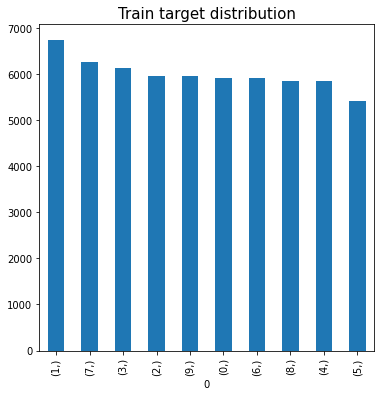

In [148]:
pd.DataFrame(target_train).value_counts().plot(kind='bar')
plt.title('Train target distribution', size=15)
plt.show()

The data seems balanced

# Build Coonolutional Neural Network

Writing good CNN is an ampiric process. We will write a CNN which was found to work well on MNIST dataset.

In [149]:
#We will use the common optimizer - Adam with learning rate of 0.001
optimizer = Adam(lr=0.001)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [73]:
model = Sequential() 

#Convolutional Layer 1
#Use 'same' padding - add 0 in order to run filters symetrically on all features.
model.add(Conv2D(filters=24, kernel_size=(5,5), input_shape=(28,28,1), activation='relu', padding='same'))

#Max pooling
model.add(MaxPooling2D(pool_size=(2,2)))

#Convolutional Layer 2
#Add strides = 2, in order to move 2 steps each time
model.add(Conv2D(filters=48, kernel_size=(5,5), activation='relu', strides=2, padding='same'))

#Max pooling
model.add(MaxPooling2D(pool_size=(2,2)))

#Convolutional Layer 3
model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu', strides=2, padding='same'))


#Max pooling
model.add(MaxPooling2D(pool_size=(2,2)))

#converting into vector
model.add(Flatten())

#Fully connected layer with 256 nuerons
model.add(Dense(units=256, activation='relu'))

#Add dropout of 20% of random nodes for better generalization
model.add(Dropout(0.2))

#For output layer with 0 - 9 (10) digits - we will use softmax activation function. It takes several outputs of the networks and returns probabilities that are all equal to one.
model.add(Dense(units=10, activation='softmax'))

#Compiler
#For clasiffication problems use: sparse_categorical_crossentropy
# The data is balanced so we will use accuracy metrics
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])

#Summary: Since batch size can vary, its size is represented by None
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 28, 28, 24)        624       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 24)       0         
 2D)                                                             
                                                                 
 conv2d_19 (Conv2D)          (None, 7, 7, 48)          28848     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 3, 3, 48)         0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 2, 2, 64)          76864     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 1, 1, 64)        

None - means no defined batch size.

the Parm shows how many parameters are trained in each layer.

All Maxpooling parameters are 0, this is because it dosn't learn anything, but reduces coplexity of the model. MAxPooling of (2,2) divides the input by 2.

Multiplications + biases:

For the first Con2D we calculate the number of parameters by: 24*(5*5*1)+24 = 624

For second Conv2D: 48*(5*5*24) + 48 = 28,848

For third Conv2D: 64*(5*5*48) + 64 = 76,864

Flatten turns it into one vector, but doesn't learn anything, so the parameters are 0

the Dense layer (FC), calculated as: 256*64+256 = 16,640

Dropout learns nothing.

Last Dense layer: 256*10+10 = 2,570

Total parameters is the sum of all trained parameters.

In [125]:
#Add augmentation to add generalziation and avoid overfittment

#Define fenerator: No horizontal or vertical flips as this could change the number
train_datagen  = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1)

validation_datagen = ImageDataGenerator()

In [126]:
#Use batch of 128 images
train_generator = train_datagen.flow(features_train, target_train, batch_size=128)

In [127]:
#Use batch of 128 images
valid_generator = validation_datagen.flow(features_test, target_test, batch_size=128)

In [128]:
#Model fot. steps per epoch are total size of data divided by batch size to completet an epoch

model.fit_generator(train_generator, steps_per_epoch=60000/128, epochs = 5, verbose=1, validation_data=valid_generator, validation_steps=10000/128)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


468/468 [==============================] - 65s 139ms/step - loss: 3.6856 - acc: 0.8545 - val_loss: 0.2182 - val_acc: 0.9421
Epoch 2/5
468/468 [==============================] - 65s 139ms/step - loss: 0.4169 - acc: 0.8843 - val_loss: 0.1638 - val_acc: 0.9551
Epoch 3/5
468/468 [==============================] - 65s 139ms/step - loss: 0.3523 - acc: 0.9020 - val_loss: 0.1412 - val_acc: 0.9593
Epoch 4/5
468/468 [==============================] - 65s 139ms/step - loss: 0.3018 - acc: 0.9150 - val_loss: 0.1239 - val_acc: 0.9632
Epoch 5/5
468/468 [==============================] - 65s 138ms/step - loss: 0.2664 - acc: 0.9242 - val_loss: 0.1136 - val_acc: 0.9662


In [129]:
scores = model.evaluate(features_test, target_test)

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 4s 11ms/step - loss: 0.1136 - acc: 0.9662
Test loss: 0.1135687381029129
Test accuracy: 0.9661999940872192


Best result of MNIST contest is 99.8%

In [130]:
results = model.predict(features_test)

In [131]:
results = pd.Series(np.argmax(results,axis = 1), name="pred_class")

In [132]:
final = pd.concat([results, pd.Series(target_test, name='real_class')], axis=1)

In [133]:
final[final['pred_class']!=final['real_class']]

,pred_class,real_class
62,5,9
151,3,9
217,5,6
241,5,9
247,6,4
...,...,...
9879,8,0
9888,0,6
9904,3,2
9905,7,3


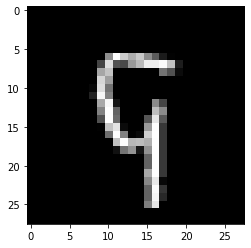

In [136]:
#See a mistaked prediction
plt.imshow(features_test[62].reshape(28,28), cmap='gray');